In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob  # finding image paths
import numpy as np  # creating numpy arrays
from skimage.io import imread  # reading images
from skimage.transform import resize  # resizing images
import cv2
import seaborn as sns 
# For reproducibility
np.random.seed(42)

import fnmatch
import os
import pickle as pkl



from sklearn import metrics
import sklearn
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay,f1_score, 
                             recall_score, precision_score, balanced_accuracy_score, RocCurveDisplay)
from sklearn.utils import class_weight

import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2



In [2]:
#Code adapted from : https://colab.research.google.com/notebooks/snippets/drive.ipynb#scrollTo=TbRbQAYqPTci

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [4]:
train_label_df=pd.read_csv('/content/drive/MyDrive/GA/Capstone/train_2_reshapedImg_labels3_b.csv')
train_label_df.head()

,image_id,label,level,label_b
0,10003_left,0,No DR,0
1,10003_right,0,No DR,0
2,10007_left,0,No DR,0
3,10007_right,0,No DR,0
4,10009_left,0,No DR,0


In [5]:
train_label_df['label_b'].value_counts()

0    21279
1     7581
Name: label_b, dtype: int64

In [6]:
pos=train_label_df['label_b'].value_counts()[1]
neg=train_label_df['label_b'].value_counts()[0]
pos,neg

(7581, 21279)

In [7]:
initial_bias = np.log([pos/neg])
initial_bias

array([-1.03207555])

In [8]:
test_label_df=pd.read_csv('/content/drive/MyDrive/GA/Capstone/test_reshapedImg_labels_b.csv')
test_label_df.head()

,image_id,label,level,label_b
0,29127_left,0,No DR,0
1,29127_right,0,No DR,0
2,29132_left,0,No DR,0
3,29132_right,0,No DR,0
4,29135_left,0,No DR,0


In [9]:
test_label_df['label_b'].value_counts()

0    2774
1    1048
Name: label_b, dtype: int64

In [10]:
index_to_level={0:'No DR', 1:'Mild DR',2:'Moderate DR',3:'Severe DR',4:'Proliferative DR'}
index_to_level

{0: 'No DR',
 1: 'Mild DR',
 2: 'Moderate DR',
 3: 'Severe DR',
 4: 'Proliferative DR'}

In [11]:
test_true_class_b=test_label_df['label_b'].to_numpy()
print(len(test_true_class_b))
test_true_class_b;

3822


In [12]:
train_true_class_b=train_label_df['label_b'].to_numpy()
print(len(train_true_class_b))
train_true_class_b;

28860


In [13]:
#function to plot model train history
def plot_history(history):
  plt.figure(figsize=(10,10))
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color='b', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='r', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    

  return

In [15]:
#creating dataframe to save model performance metrics
eval_df=pd.DataFrame(columns=['class','precision','recall','f1-score','support','auc','prc','model_no','comment'])

In [ ]:
# eval_df.to_csv('/content/drive/MyDrive/GA/Capstone/BinaryModels/model_evaluation.csv', index=False)

In [16]:
#model to evaluate model performance
def bmodel_eval(model, model_no, comment, test, val):
  eval_df=pd.read_csv('/content/drive/MyDrive/GA/Capstone/BinaryModels/model_evaluation.csv')
  print('-----TEST--------')
  weighted_results_test = model.evaluate(test_b, verbose=1)
  for name, value in zip(model.metrics_names, weighted_results_test):
    print(name, ': ', value)
  print('-------------')


  print('-----VAL--------')
  # val_true_class_b=get_label(val_b)
  weighted_results = model.evaluate(val_b, verbose=1)
  for name, value in zip(model.metrics_names, weighted_results):
    print(name, ': ', value)
  print('-------------')

  test_pred_class=np.round(model.predict(test_b))
  print(len(test_pred_class))
  # print(tf.math.confusion_matrix(labels=test_true_class_b, predictions=test_pred_class, num_classes=2))

  print(classification_report(test_true_class_b, test_pred_class,zero_division=0))

  cm = tf.math.confusion_matrix(labels=test_true_class_b, predictions=test_pred_class, num_classes=2)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  # print('True Negatives: ', cm[0][0])
  # print('False Positives: ', cm[0][1])
  # print('False Negatives: ', cm[1][0])
  # print('True Positives: ', cm[1][1])
  # print('Total: ', np.sum(cm[1]))


  
  report=classification_report(test_true_class_b, test_pred_class, zero_division=0, output_dict=True)
  report_df=pd.DataFrame(report)
  report_df=report_df.transpose()
  report_df.reset_index(inplace=True)
  report_df.rename(columns={'index':'class'},inplace=True)
  report_df['auc']=weighted_results_test[8]
  report_df['prc']=weighted_results_test[9]
  report_df['model_no']=model_no
  report_df['comment']=comment
  

  #saving metrics
  eval_df=pd.concat([eval_df,report_df], axis=0);

  eval_df.to_csv('/content/drive/MyDrive/GA/Capstone/BinaryModels/model_evaluation.csv',index=False)

  
  return eval_df

All models fit with batch size of 512 unless otherwise mentioned:  
inresnet (Inception Resnet V2)- 256 batch size

## Modeling with whole datset-CNN

In [18]:
#https://androidkt.com/use-image-dataset-from-directory-with-and-without-label-list-in-keras/

#creating binary train and val batches 

data_dir='/content/drive/MyDrive/GA/Capstone/train'
IMG_height = 224
IMG_width = 224
batch_size=512


train_b = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=42,
  labels=train_label_df['label_b'].to_numpy().tolist(),
  label_mode='int',
  # class_names=["0", "1", "2", "3", "4"],
  validation_split=0.2,
  subset="training",
  image_size=(IMG_height, IMG_width),
  batch_size=batch_size,
  shuffle=False)
 
val_b = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=42,
  labels=train_label_df['label_b'].to_numpy().tolist(),
  label_mode='int',
  # class_names=["0", "1", "2", "3", "4"],
  validation_split=0.2,
  subset="validation",
  image_size=(IMG_height, IMG_width),
  batch_size=batch_size,
  shuffle=False)


Found 28860 files belonging to 1 classes.
Using 23088 files for training.
Found 28860 files belonging to 1 classes.
Using 5772 files for validation.


In [19]:
#https://androidkt.com/use-image-dataset-from-directory-with-and-without-label-list-in-keras/

# creating binary test batch

data_dir='/content/drive/MyDrive/GA/Capstone/test_train_3/test_reshapedImg_parent'
IMG_height = 224
IMG_width = 224
batch_size=512




test_b = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=42,
  labels=test_label_df['label_b'].to_numpy().tolist(),
  label_mode='int',
  validation_split=0.0,
  image_size=(IMG_height, IMG_width),
  batch_size=batch_size,
  shuffle=False)


Found 3822 files belonging to 1 classes.


In [ ]:
def get_label(data):
  for image, label in data:
    y=label.numpy()
  return y

In [ ]:
#Generating Class Weights to plugin during CNN model fitting to combat with imbalanced classes



weights_b_master=class_weight.compute_class_weight(class_weight='balanced',
                                    classes=np.unique(np.array(train_label_df['label_b'])), 
                                    y=np.array(train_label_df['label_b']))
classes_b_master=np.unique(np.array(train_label_df['label_b']))
weights_b_dict_master=dict(zip(classes_b_master, weights_b_master))
weights_b_dict_master

{0: 0.678133370929085, 1: 1.9034428175702414}

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:

es=EarlyStopping(monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

### CNN1 Binary Classification 

---


metrics  
setting initial bias  
bigger batch size=512  
help from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [ ]:


model1_b=Sequential()

# Add a convolutional layer.

model1_b.add(Rescaling(1./255, input_shape=(IMG_height, IMG_width,3)))

model1_b.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model1_b.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model1_b.add(MaxPooling2D(pool_size=(2, 2)))


model1_b.add(Conv2D(filters=128,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model1_b.add(Conv2D(128,
                  kernel_size = (3, 3),
                  activation='relu'))
model1_b.add(Conv2D(128,
                  kernel_size = (1, 1),
                  activation='relu'))
model1_b.add(MaxPooling2D(pool_size=(2,2)))



model1_b.add(Conv2D(256,
                  kernel_size = (3, 3),
                  activation='relu'))
model1_b.add(Conv2D(256,
                  kernel_size = (3, 3),
                  activation='relu'))
model1_b.add(Conv2D(256,
                  kernel_size = (1, 1),
                  activation='relu'))
model1_b.add(MaxPooling2D(pool_size=(2,2)))




model1_b.add(Flatten())


model1_b.add(Dense(128,
                activation='relu', kernel_regularizer=l2(0.005)))
model1_b.add(Dropout(0.5))


model1_b.add(Dense(256,
                activation='relu', kernel_regularizer=l2(0.005)))
model1_b.add(Dropout(0.5))


model1_b.add(Dense(256,
                activation='relu', kernel_regularizer=l2(0.005)))
model1_b.add(Dropout(0.5))


model1_b.add(Dense(1,
                 activation='sigmoid',
                 bias_initializer=tf.keras.initializers.Constant(initial_bias)))


model1_b.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=METRICS,
              )

In [ ]:
model1_b.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 conv2d_17 (Conv2D)          (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 108, 108, 128)     73856     
                                                                 
 conv2d_19 (Conv2D)          (None, 106, 106, 128)     147584    
                                                      

In [ ]:
history_model1_b=model1_b.fit(train_b,
                            validation_data=val_b,
                            epochs=20,
                            verbose=1,
                            callbacks=[es])


model1_b.save('/content/drive/MyDrive/GA/Capstone/BinaryModels/model1_b.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model1_b_history.pkl','wb') as model_history:
  pkl.dump(history_model1_b, model_history)


In [ ]:
model1_b=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/BinaryModels/model1_b.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model1_b_history.pkl','rb') as model_history:
  history_model1_b=pkl.load(model_history)


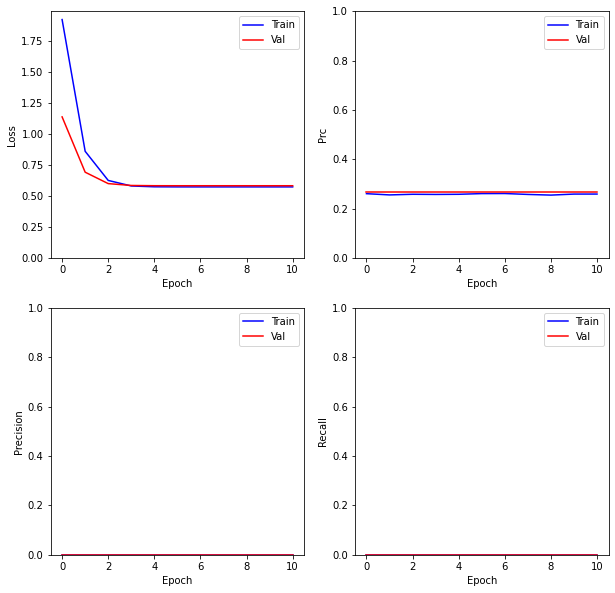

In [ ]:
plot_history(history_model1_b)

-----TEST--------
8/8 [==============================] - 7s 802ms/step - loss: 1.1416 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2774.0000 - fn: 1048.0000 - accuracy: 0.7258 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.2742
loss :  1.1416128873825073
tp :  0.0
fp :  0.0
tn :  2774.0
fn :  1048.0
accuracy :  0.7257980108261108
precision :  0.0
recall :  0.0
auc :  0.5
prc :  0.27420198917388916
-------------
-----VAL--------
12/12 [==============================] - 9s 765ms/step - loss: 1.1372 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4214.0000 - fn: 1558.0000 - accuracy: 0.7301 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.2699
loss :  1.1371620893478394
tp :  0.0
fp :  0.0
tn :  4214.0
fn :  1558.0
accuracy :  0.730076253414154
precision :  0.0
recall :  0.0
auc :  0.5
prc :  0.26992377638816833
-------------
8/8 [==============================] - 7s 840ms/step
3822
              precision    recall  f1-score   support

           0       0.73  

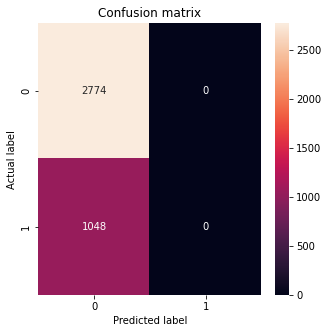

In [ ]:
eval_df=bmodel_eval(model1_b,1, 'Model1 b CNN', test_b, val_b)

### CNN weighted model

In [ ]:
history_model1_b_weighted=model1_b.fit(train_b,
                            validation_data=val_b,
                            epochs=20,
                            verbose=1,
                            callbacks=[es],
                            class_weight=weights_b_dict_master)

In [ ]:
model1_b.save('/content/drive/MyDrive/GA/Capstone/BinaryModels/model1_b_weighted.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model1_b_weighted_history.pkl','wb') as model_history:
  pkl.dump(history_model1_b_weighted, model_history)

In [ ]:
model1_bW=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/BinaryModels/model1_b_weighted.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model1_b_weighted_history.pkl','rb') as model_history:
  history_model1_bW=pkl.load(model_history)


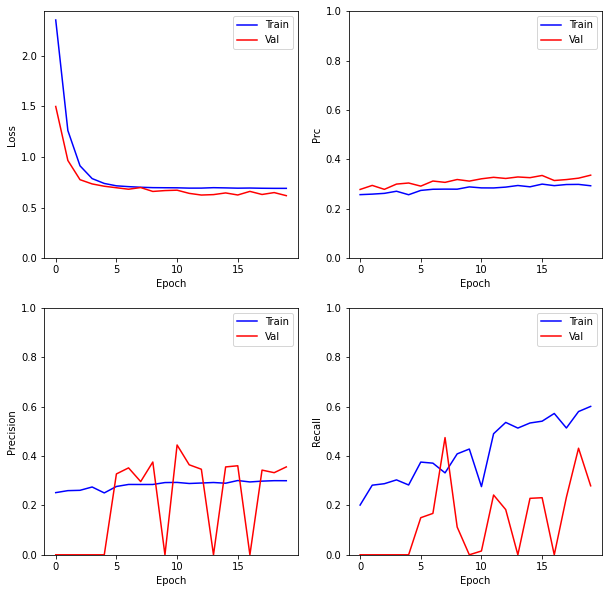

In [ ]:
plot_history(history_model1_bW)

-----TEST--------
8/8 [==============================] - 7s 821ms/step - loss: 0.6207 - tp: 299.0000 - fp: 522.0000 - tn: 2252.0000 - fn: 749.0000 - accuracy: 0.6675 - precision: 0.3642 - recall: 0.2853 - auc: 0.5949 - prc: 0.3416
loss :  0.6207068562507629
tp :  299.0
fp :  522.0
tn :  2252.0
fn :  749.0
accuracy :  0.6674516201019287
precision :  0.364190012216568
recall :  0.28530535101890564
auc :  0.5949430465698242
prc :  0.34156909584999084
-------------
-----VAL--------
12/12 [==============================] - 10s 775ms/step - loss: 0.6183 - tp: 435.0000 - fp: 788.0000 - tn: 3426.0000 - fn: 1123.0000 - accuracy: 0.6689 - precision: 0.3557 - recall: 0.2792 - auc: 0.5936 - prc: 0.3364
loss :  0.6183128356933594
tp :  435.0
fp :  788.0
tn :  3426.0
fn :  1123.0
accuracy :  0.6689189076423645
precision :  0.35568276047706604
recall :  0.2792041003704071
auc :  0.59355229139328
prc :  0.33640390634536743
-------------
8/8 [==============================] - 7s 840ms/step
3822
       

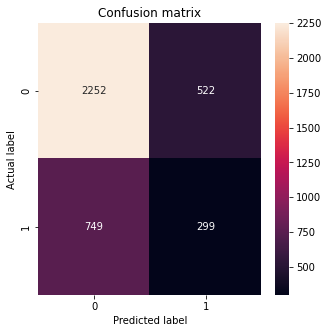

In [ ]:
eval_df=bmodel_eval(model1_bW, 2, 'Model1 b CNN weighted', test_b, val_b)

### CNN2

In [ ]:
model2_b=Sequential()


model2_b.add(Rescaling(1./255, input_shape=(IMG_height, IMG_width,3)))


model2_b.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model2_b.add(MaxPooling2D(pool_size=(2, 2)))


model2_b.add(Conv2D(filters=256,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model2_b.add(MaxPooling2D(pool_size=(2,2)))


model2_b.add(Conv2D(512,
                  kernel_size = (3, 3),
                  activation='relu'))
model2_b.add(MaxPooling2D(pool_size=(2,2)))



model2_b.add(Flatten())


model2_b.add(Dense(128,
                activation='relu'))
model2_b.add(Dropout(0.5))


model2_b.add(Dense(256,
                activation='relu', kernel_regularizer=l2(0.0005)))
model2_b.add(Dropout(0.5))

model2_b.add(Dense(512,
                activation='relu', kernel_regularizer=l2(0.0005)))
model2_b.add(Dropout(0.5))

model2_b.add(Dense(512,
                activation='relu', kernel_regularizer=l2(0.0005)))
model2_b.add(Dropout(0.5))


model2_b.add(Dense(1,
                 activation='sigmoid',
                 bias_initializer=tf.keras.initializers.Constant(initial_bias)))


model2_b.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=METRICS,
              )


In [ ]:
model2_b.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_206 (Conv2D)         (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 conv2d_207 (Conv2D)         (None, 109, 109, 256)     147712    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 54, 54, 256)      0         
 2D)                                                             
                                                                 
 conv2d_208 (Conv2D)         (None, 52, 52, 512)      

In [ ]:
history_model2_b_weighted=model2_b.fit(train_b,
                            validation_data=val_b,
                            epochs=20,
                            verbose=1,
                            callbacks=[es],
                            class_weight=weights_b_dict_master)

model2_b.save('/content/drive/MyDrive/GA/Capstone/BinaryModels/model2_b_weighted.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model2_b_weighted_history.pkl','wb') as model_history:
  pkl.dump(history_model2_b_weighted, model_history)

In [ ]:
model2_b=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/BinaryModels/model2_b_weighted.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model2_b_weighted_history.pkl','rb') as model_history:
  history_model2_b_weighted=pkl.load(model_history)

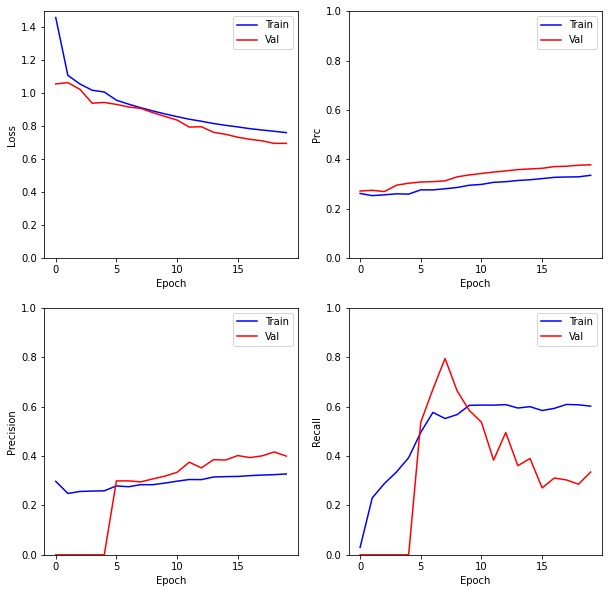

In [ ]:
plot_history(history_model2_b_weighted)

-----TEST--------
8/8 [==============================] - 7s 559ms/step - loss: 0.7009 - tp: 388.0000 - fp: 563.0000 - tn: 2211.0000 - fn: 660.0000 - accuracy: 0.6800 - precision: 0.4080 - recall: 0.3702 - auc: 0.6297 - prc: 0.3864
loss :  0.7009457349777222
tp :  388.0
fp :  563.0
tn :  2211.0
fn :  660.0
accuracy :  0.6800104379653931
precision :  0.40799158811569214
recall :  0.37022900581359863
auc :  0.6296745538711548
prc :  0.38643646240234375
-------------
-----VAL--------
12/12 [==============================] - 6s 448ms/step - loss: 0.6967 - tp: 522.0000 - fp: 785.0000 - tn: 3429.0000 - fn: 1036.0000 - accuracy: 0.6845 - precision: 0.3994 - recall: 0.3350 - auc: 0.6330 - prc: 0.3783
loss :  0.6967343091964722
tp :  522.0
fp :  785.0
tn :  3429.0
fn :  1036.0
accuracy :  0.6845114231109619
precision :  0.399387925863266
recall :  0.3350449204444885
auc :  0.6329885125160217
prc :  0.37826773524284363
-------------
8/8 [==============================] - 4s 466ms/step
3822
      

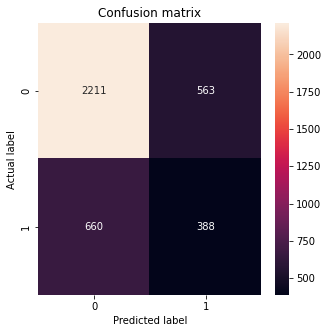

In [ ]:
eval_df=bmodel_eval(model2_b,3, 'Model2 b CNN weighted', test_b, val_b)

### CNN3  
HSV  

In [ ]:

#https://stackoverflow.com/questions/43033739/how-to-convert-images-color-space-in-keras
def hsv_conversion(x):
     
    return tf.image.rgb_to_hsv(x)

In [ ]:
data_aug = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  # tf.keras.layers.RandomFlip("horizontal_and_vertical")
  # tf.keras.layers.RandomBrightness(factor=0.3, value_range=(0.0, 1.0), seed=42)
])

In [ ]:
model3_b=Sequential()


model3_b.add(Rescaling(1./255, input_shape=(IMG_height, IMG_width,3)))
model3_b.add(Lambda(hsv_conversion, input_shape=(IMG_height, IMG_width,3)))
# model3_b.add(data_aug)

model3_b.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 

model3_b.add(MaxPooling2D(pool_size=(2, 2)))


model3_b.add(Conv2D(filters=256,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 

model3_b.add(MaxPooling2D(pool_size=(2,2)))


model3_b.add(Conv2D(64,
                  kernel_size = (3, 3),
                  activation='relu'))
model3_b.add(MaxPooling2D(pool_size=(2,2)))



model3_b.add(Flatten())


model3_b.add(Dense(128,
                activation='relu'))
model3_b.add(Dropout(0.5))


model3_b.add(Dense(512,
                activation='relu', kernel_regularizer=l2(0.0005), bias_regularizer=l2(1e-4)))
model3_b.add(Dropout(0.5))

model3_b.add(Dense(256,
                activation='relu', kernel_regularizer=l2(0.0005), bias_regularizer=l2(1e-4)))
model3_b.add(Dropout(0.5))

# model3_b.add(Dense(512,
#                 activation='relu', kernel_regularizer=l2(0.0005), bias_regularizer=l2(1e-4)))
# model3_b.add(Dropout(0.5))


model3_b.add(Dense(1,
                 activation='sigmoid',
                 bias_initializer=tf.keras.initializers.Constant(initial_bias)))


model3_b.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=METRICS,
              )


In [ ]:
history_model3_b_weighted=model3_b.fit(train_b,
                            validation_data=val_b,
                            epochs=30,
                            verbose=1,
                            callbacks=[es],
                            class_weight=weights_b_dict_master)

model3_b.save('/content/drive/MyDrive/GA/Capstone/BinaryModels/model3_b_weighted.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model3_b_weighted_history.pkl','wb') as model_history:
  pkl.dump(history_model3_b_weighted, model_history)

In [31]:
model3_b=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/BinaryModels/model3_b_weighted.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model3_b_weighted_history.pkl','rb') as model_history:
  history_model3_b_weighted=pkl.load(model_history)

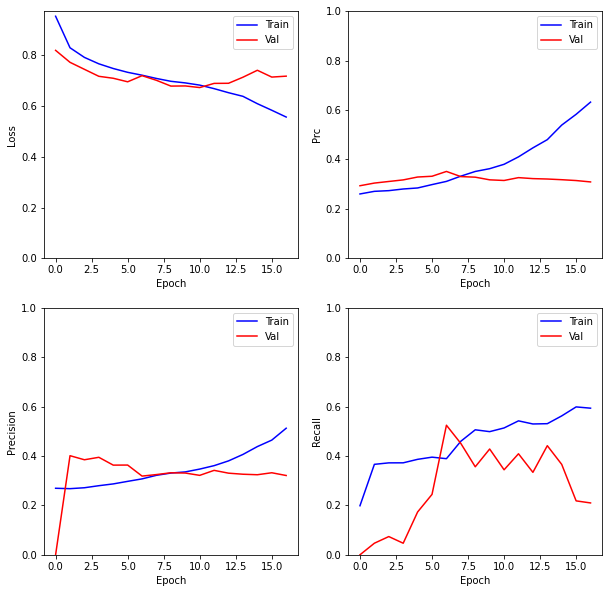

In [ ]:
plot_history(history_model3_b_weighted)

-----TEST--------
8/8 [==============================] - 5s 422ms/step - loss: 0.7197 - tp: 563.0000 - fp: 1168.0000 - tn: 1606.0000 - fn: 485.0000 - accuracy: 0.5675 - precision: 0.3252 - recall: 0.5372 - auc: 0.5802 - prc: 0.3628
loss :  0.7196951508522034
tp :  563.0
fp :  1168.0
tn :  1606.0
fn :  485.0
accuracy :  0.5675039291381836
precision :  0.32524552941322327
recall :  0.5372137427330017
auc :  0.5802474617958069
prc :  0.36280953884124756
-------------
-----VAL--------
12/12 [==============================] - 5s 370ms/step - loss: 0.7199 - tp: 817.0000 - fp: 1748.0000 - tn: 2466.0000 - fn: 741.0000 - accuracy: 0.5688 - precision: 0.3185 - recall: 0.5244 - auc: 0.5876 - prc: 0.3515
loss :  0.7199487090110779
tp :  817.0
fp :  1748.0
tn :  2466.0
fn :  741.0
accuracy :  0.5687803030014038
precision :  0.3185185194015503
recall :  0.5243902206420898
auc :  0.5875645875930786
prc :  0.35150960087776184
-------------
8/8 [==============================] - 3s 402ms/step
3822
    

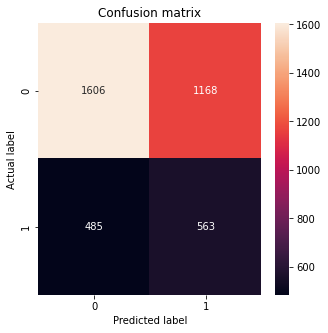

In [ ]:
eval_df=bmodel_eval(model3_b,4, 'Model3 b CNN weighted', test_b, val_b)

In [32]:
test_pred_class_4=np.round(model3_b.predict(test_b))

8/8 [==============================] - 5s 481ms/step


In [ ]:
test_true_class_b

array([0, 0, 0, ..., 0, 0, 0])

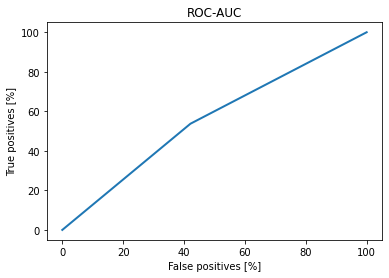

In [36]:
fp, tp, _ = sklearn.metrics.roc_curve(test_true_class_b, test_pred_class_4)

plt.plot(100*fp, 100*tp, linewidth=2)
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')
plt.title('ROC-AUC');

# Transfer Learning


In [ ]:
!pip install --upgrade tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### MobileNet V2  
trained on (train1, train_2, train_3, train_4)

In [ ]:
feature_extractor='https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

In [ ]:
feature_extractor_layer=hub.KerasLayer(feature_extractor, input_shape=(224,224,3))

In [ ]:
feature_extractor_layer.trainable=False

In [ ]:
es=EarlyStopping(monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model2_b_mn=Sequential()

model2_b_mn.add(feature_extractor_layer)

model2_b_mn.add(Dropout(0.5))

model2_b_mn.add(Dense(1, activation='sigmoid'))


model2_b_mn.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=METRICS,
              )


In [ ]:
model2_b_mn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
history_model2_b_mn=model2_b_mn.fit(train_b,
                            validation_data=val_b,
                            epochs=20,
                            verbose=1,
                            # callbacks=[es]
                            )

model2_b_mn.save('/content/drive/MyDrive/GA/Capstone/BinaryModels/model2_b_mn.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model2_b_mn_history.pkl','wb') as model_history:
  pkl.dump(history_model2_b_mn, model_history)

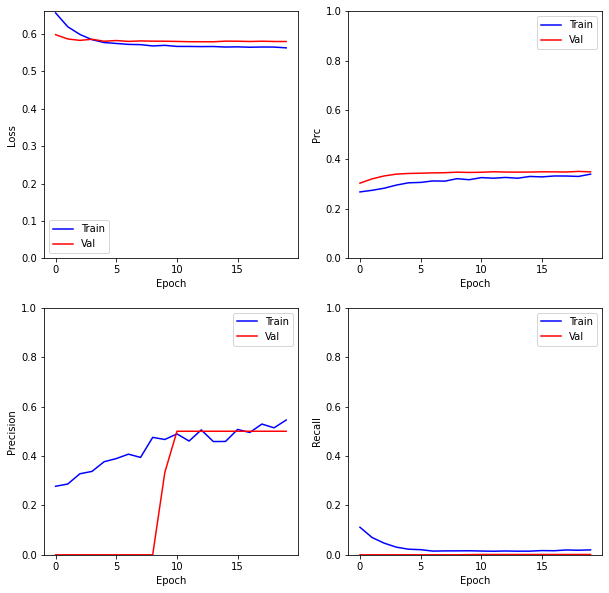

In [ ]:
plot_history(history_model2_b_mn)

-----TEST--------
8/8 [==============================] - 528s 65s/step - loss: 0.5805 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2774.0000 - fn: 1048.0000 - accuracy: 0.7258 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6210 - prc: 0.3791
loss :  0.5804720520973206
tp :  0.0
fp :  0.0
tn :  2774.0
fn :  1048.0
accuracy :  0.7257980108261108
precision :  0.0
recall :  0.0
auc :  0.6209546327590942
prc :  0.37913987040519714
-------------
-----VAL--------
12/12 [==============================] - 17s 1s/step - loss: 0.5798 - tp: 2.0000 - fp: 2.0000 - tn: 4212.0000 - fn: 1556.0000 - accuracy: 0.7301 - precision: 0.5000 - recall: 0.0013 - auc: 0.5994 - prc: 0.3498
loss :  0.5798137187957764
tp :  2.0
fp :  2.0
tn :  4212.0
fn :  1556.0
accuracy :  0.730076253414154
precision :  0.5
recall :  0.00128369708545506
auc :  0.5994497537612915
prc :  0.3497980535030365
-------------
8/8 [==============================] - 12s 1s/step
3822
tf.Tensor(
[[2774    0]
 [1048    0]], shape=(2, 2), dt

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


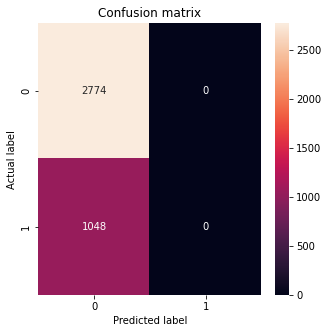

In [ ]:
bmodel_eval(model2_b_mn, 'Model2_b MobileNet')

### MobileNet Weighted

In [ ]:
history_model2_b_mn_wt=model2_b_mn.fit(train_b,
                            validation_data=val_b,
                            epochs=20,
                            verbose=1,
                            callbacks=[es],
                            class_weight=weights_b_dict_master
                            )

model2_b_mn.save('/content/drive/MyDrive/GA/Capstone/BinaryModels/model2_b_mnWeighted.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model2_b_mnWeighted.pkl','wb') as model:
  pkl.dump(model2_b_mn, model)

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model2_b_mn_weighted_history.pkl','wb') as model_history:
  pkl.dump(history_model2_b_mn_wt, model_history)


In [ ]:
with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model2_b_mnWeighted.pkl','rb') as model:
  model2_b_mn=pkl.load(model)

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model2_b_mn_weighted_history.pkl','rb') as model_history:
  history_model2_b_mn_wt=pkl.load(model_history)

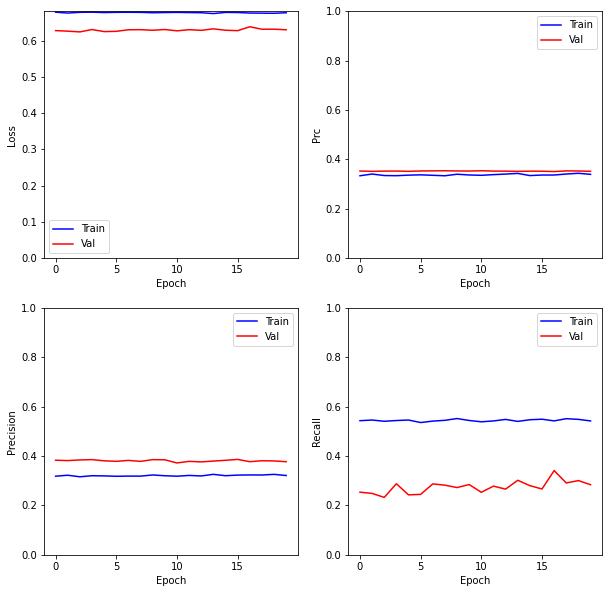

In [ ]:
plot_history(history_model2_b_mn_wt)

-----TEST--------
8/8 [==============================] - 6s 579ms/step - loss: 0.6257 - tp: 331.0000 - fp: 448.0000 - tn: 2326.0000 - fn: 717.0000 - accuracy: 0.6952 - precision: 0.4249 - recall: 0.3158 - auc: 0.6290 - prc: 0.3845
loss :  0.6256914138793945
tp :  331.0
fp :  448.0
tn :  2326.0
fn :  717.0
accuracy :  0.6951857805252075
precision :  0.4249037206172943
recall :  0.3158397078514099
auc :  0.6289973258972168
prc :  0.3844749331474304
-------------
-----VAL--------
12/12 [==============================] - 4s 340ms/step - loss: 0.6296 - tp: 443.0000 - fp: 734.0000 - tn: 3480.0000 - fn: 1115.0000 - accuracy: 0.6797 - precision: 0.3764 - recall: 0.2843 - auc: 0.6049 - prc: 0.3520
loss :  0.6296353936195374
tp :  443.0
fp :  734.0
tn :  3480.0
fn :  1115.0
accuracy :  0.679660439491272
precision :  0.3763806223869324
recall :  0.28433889150619507
auc :  0.6048753261566162
prc :  0.3520112633705139
-------------
8/8 [==============================] - 5s 549ms/step
3822
         

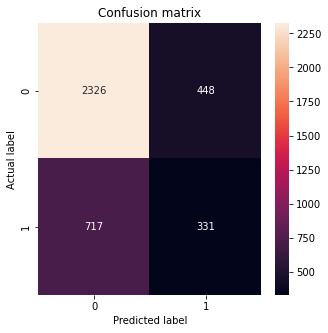

In [ ]:
eval_df=bmodel_eval(model2_b_mn, 6, 'Model2_b MN weighted', test_b,val_b)

### VGG

Code adapted from https://github.com/krishnaik06/Transfer-Learning/blob/master/face_Recognition.py

In [ ]:
vgg16 = VGG16(input_shape=[224,224] + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 5s 0us/step


In [ ]:
for layer in vgg16.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg16.output)

prediction = Dense(1, activation='sigmoid')(x)

model3b_vgg = Model(inputs=vgg16.input, outputs=prediction)

model3b_vgg.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=METRICS,
              )
              
model3b_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
history_model3b_vgg = model3b_vgg.fit(train_b,
                            validation_data=val_b,
                            epochs=11,
                            verbose=1                            
                            )

model3b_vgg.save('/content/drive/MyDrive/GA/Capstone/BinaryModels/model3b_vgg.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model3b_vgg_history.pkl','wb') as model_history:
  pkl.dump(history_model3b_vgg, model_history)

In [ ]:
model3b_vgg=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/BinaryModels/model3b_vgg.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model3b_vgg_history.pkl','rb') as model_history:
  history_model3b_vgg =pkl.load(model_history)

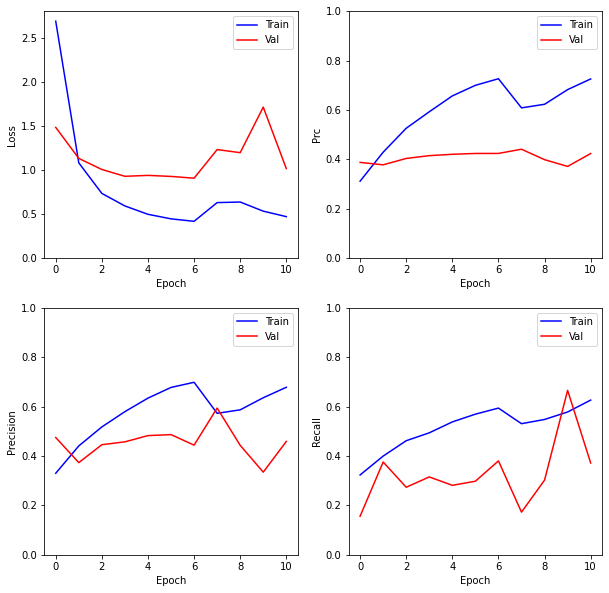

In [ ]:
plot_history(history_model3b_vgg)

-----TEST--------
8/8 [==============================] - 16s 928ms/step - loss: 1.0417 - tp: 400.0000 - fp: 475.0000 - tn: 2299.0000 - fn: 648.0000 - accuracy: 0.7062 - precision: 0.4571 - recall: 0.3817 - auc: 0.6527 - prc: 0.4260
loss :  1.0416628122329712
tp :  400.0
fp :  475.0
tn :  2299.0
fn :  648.0
accuracy :  0.7061747908592224
precision :  0.4571428596973419
recall :  0.38167938590049744
auc :  0.6526765823364258
prc :  0.42603182792663574
-------------
-----VAL--------
12/12 [==============================] - 8s 694ms/step - loss: 1.0200 - tp: 579.0000 - fp: 683.0000 - tn: 3531.0000 - fn: 979.0000 - accuracy: 0.7121 - precision: 0.4588 - recall: 0.3716 - auc: 0.6506 - prc: 0.4240
loss :  1.0200086832046509
tp :  579.0
fp :  683.0
tn :  3531.0
fn :  979.0
accuracy :  0.7120581865310669
precision :  0.45879557728767395
recall :  0.3716302812099457
auc :  0.6506440043449402
prc :  0.42402687668800354
-------------
8/8 [==============================] - 5s 617ms/step
3822
      

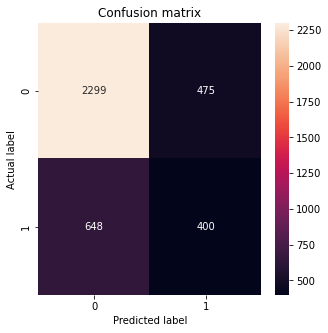

In [ ]:
eval_df=bmodel_eval(model3b_vgg, 7, 'Model3_b VGG16', test_b, val_b)

### VGG weighted

In [ ]:
es=EarlyStopping(monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

history_model3b_vggW = model3b_vgg.fit(train_b,
                            validation_data=val_b,
                            epochs=25,
                            verbose=1,
                            callbacks=[es],
                            class_weight=weights_b_dict_master                            
                            )

model3b_vgg.save('/content/drive/MyDrive/GA/Capstone/BinaryModels/model3b_vggW.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model3b_vggW_history.pkl','wb') as model_history:
  pkl.dump(history_model3b_vggW, model_history)

In [ ]:
model3b_vggW=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/BinaryModels/model3b_vggW.h5')


with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model3b_vggW_history.pkl','rb') as model_history:
 history_model3b_vggW =pkl.load(model_history)

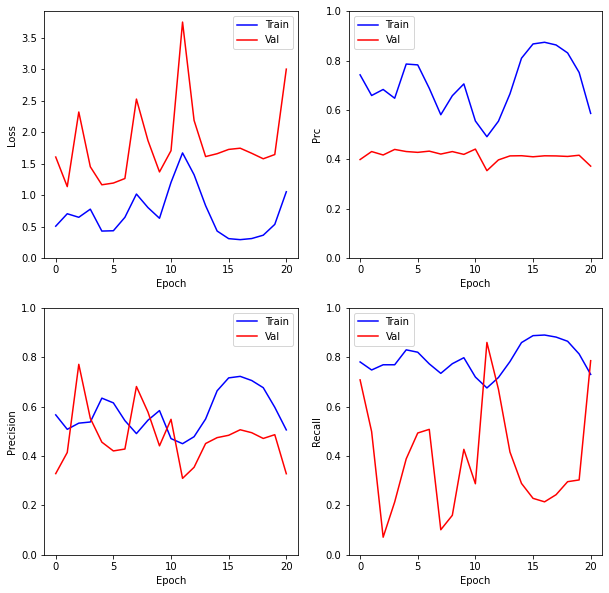

In [ ]:
plot_history(history_model3b_vggW)

-----TEST--------
8/8 [==============================] - 6s 587ms/step - loss: 1.7538 - tp: 303.0000 - fp: 290.0000 - tn: 2484.0000 - fn: 745.0000 - accuracy: 0.7292 - precision: 0.5110 - recall: 0.2891 - auc: 0.6487 - prc: 0.4470
loss :  1.7538212537765503
tp :  303.0
fp :  290.0
tn :  2484.0
fn :  745.0
accuracy :  0.7291993498802185
precision :  0.5109612345695496
recall :  0.2891221344470978
auc :  0.6486812829971313
prc :  0.44701245427131653
-------------
-----VAL--------
12/12 [==============================] - 6s 519ms/step - loss: 1.7073 - tp: 448.0000 - fp: 369.0000 - tn: 3845.0000 - fn: 1110.0000 - accuracy: 0.7438 - precision: 0.5483 - recall: 0.2875 - auc: 0.6474 - prc: 0.4419
loss :  1.7072967290878296
tp :  448.0
fp :  369.0
tn :  3845.0
fn :  1110.0
accuracy :  0.7437629699707031
precision :  0.5483475923538208
recall :  0.28754812479019165
auc :  0.6473520398139954
prc :  0.4419245719909668
-------------
8/8 [==============================] - 5s 575ms/step
3822
       

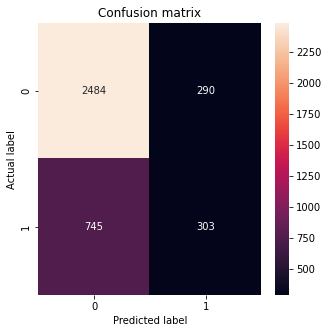

In [ ]:
eval_df=bmodel_eval(model3b_vggW, 8, 'Model3b VGG Weighted', test_b, val_b)

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

## Inception ResNet V2

In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2  
from keras.applications.inception_resnet_v2 import preprocess_input

In [ ]:
inresnet = InceptionResNetV2(input_shape=[224,224] + [3], weights='imagenet', include_top=False)


219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
for layer in inresnet.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(inresnet.output)

prediction = Dense(1, activation='sigmoid')(x)

model4b_inresnet = Model(inputs=inresnet.input, outputs=prediction)

model4b_inresnet.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=METRICS,
              )
              
model4b_inresnet.summary()

In [ ]:
#ran with batch size=256
history_model4b_inresnet =model4b_inresnet.fit(train_b,
                            validation_data=val_b,
                            epochs=10,
                            verbose=1,
                                                 
                            )

model4b_inresnet.save('/content/drive/MyDrive/GA/Capstone/BinaryModels/model4b_inresnet.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model4b_inresnet_history.pkl','wb') as model_history:
  pkl.dump(history_model4b_inresnet, model_history)

In [20]:
model4b_inresnet=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/BinaryModels/model4b_inresnet.h5')


with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model4b_inresnet_history.pkl','rb') as model_history:
 history_model4b_inresnet =pkl.load(model_history)

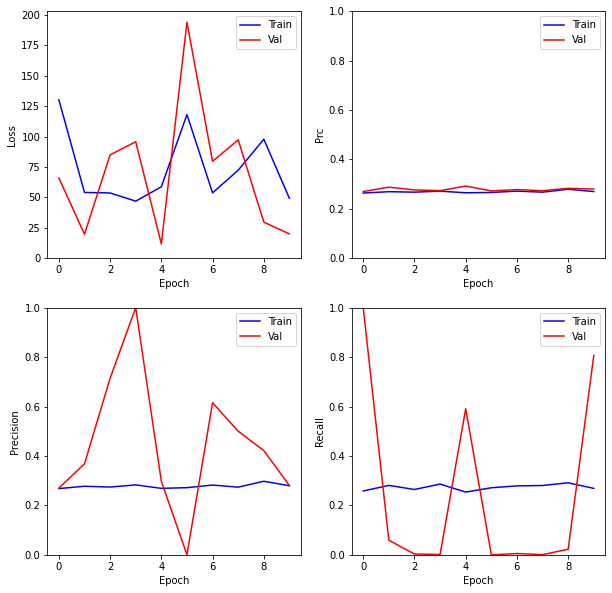

In [ ]:
plot_history(history_model4b_inresnet)

-----TEST--------
15/15 [==============================] - 10s 332ms/step - loss: 20.0426 - tp: 856.0000 - fp: 2134.0000 - tn: 640.0000 - fn: 192.0000 - accuracy: 0.3914 - precision: 0.2863 - recall: 0.8168 - auc: 0.5256 - prc: 0.2858
loss :  20.042556762695312
tp :  856.0
fp :  2134.0
tn :  640.0
fn :  192.0
accuracy :  0.39141809940338135
precision :  0.2862876355648041
recall :  0.8167939186096191
auc :  0.525569498538971
prc :  0.2857660949230194
-------------
-----VAL--------
23/23 [==============================] - 6s 271ms/step - loss: 20.0970 - tp: 1261.0000 - fp: 3239.0000 - tn: 975.0000 - fn: 297.0000 - accuracy: 0.3874 - precision: 0.2802 - recall: 0.8094 - auc: 0.5219 - prc: 0.2800
loss :  20.096973419189453
tp :  1261.0
fp :  3239.0
tn :  975.0
fn :  297.0
accuracy :  0.38738739490509033
precision :  0.28022223711013794
recall :  0.8093709945678711
auc :  0.5219193696975708
prc :  0.2800058126449585
-------------
15/15 [==============================] - 7s 239ms/step
3822


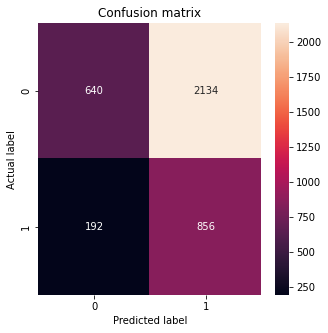

In [ ]:
eval_df=bmodel_eval(model4b_inresnet, 9,'Model4b InceptionResnetV2', test_b, val_b)

In [21]:
test_pred_class=np.round(model4b_inresnet.predict(test_b))

8/8 [==============================] - 119s 13s/step


In [25]:
#https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
def plot_roc(name, labels, predictions):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

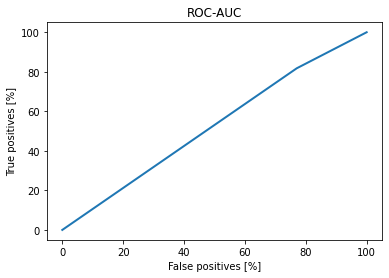

In [37]:
fp, tp, _ = sklearn.metrics.roc_curve(test_true_class_b, test_pred_class)

plt.plot(100*fp, 100*tp, linewidth=2)
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')
plt.title('ROC-AUC');

### Inception ResNet V2 Weighted

In [ ]:
#ran with batch size=256

es=EarlyStopping(monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


history_model4b_inresnetWt =model4b_inresnet.fit(train_b,
                            validation_data=val_b,
                            epochs=20,
                            verbose=1,
                            callbacks=[es],
                            class_weight=weights_b_dict_master                       
                                                 
                            )

model4b_inresnet.save('/content/drive/MyDrive/GA/Capstone/BinaryModels/model4b_inresnetWt.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model4b_inresnetWt_history.pkl','wb') as model_history:
  pkl.dump(history_model4b_inresnetWt, model_history)

In [ ]:
model4b_inresnetWt=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/BinaryModels/model4b_inresnetWt.h5')


with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model4b_inresnetWt_history.pkl','rb') as model_history:
 history_model4b_inresnetWt =pkl.load(model_history)

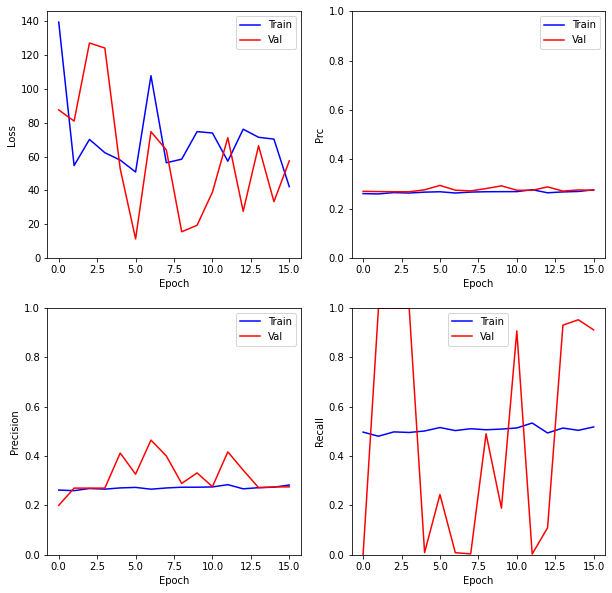

In [ ]:
plot_history(history_model4b_inresnetWt)

-----TEST--------
15/15 [==============================] - 8s 246ms/step - loss: 11.4641 - tp: 231.0000 - fp: 496.0000 - tn: 2278.0000 - fn: 817.0000 - accuracy: 0.6565 - precision: 0.3177 - recall: 0.2204 - auc: 0.5213 - prc: 0.2910
loss :  11.464119911193848
tp :  231.0
fp :  496.0
tn :  2278.0
fn :  817.0
accuracy :  0.6564626097679138
precision :  0.3177441656589508
recall :  0.22041985392570496
auc :  0.5212588310241699
prc :  0.2910176217556
-------------
-----VAL--------
23/23 [==============================] - 5s 229ms/step - loss: 11.4235 - tp: 381.0000 - fp: 783.0000 - tn: 3431.0000 - fn: 1177.0000 - accuracy: 0.6604 - precision: 0.3273 - recall: 0.2445 - auc: 0.5295 - prc: 0.2954
loss :  11.423543930053711
tp :  381.0
fp :  783.0
tn :  3431.0
fn :  1177.0
accuracy :  0.6604296565055847
precision :  0.32731959223747253
recall :  0.24454428255558014
auc :  0.5295108556747437
prc :  0.2953547537326813
-------------
15/15 [==============================] - 7s 239ms/step
3822
   

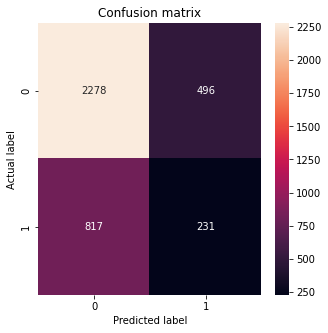

In [ ]:
eval_df=bmodel_eval(model4b_inresnetWt, 10, 'Model4b InceptionResnetV2 Weighted', test_b, val_b)

### Inception ResNetV2 with one hidden layer

In [ ]:
x = Flatten()(inresnet.output)
y=Dense(512, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)

model5b_inresnet = Model(inputs=inresnet.input, outputs=prediction)

model5b_inresnet.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=METRICS,
              )
              
model5b_inresnet.summary();

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
#ran with batch size=512

es=EarlyStopping(monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


history_model5b_inresnet =model5b_inresnet.fit(train_b,
                            validation_data=val_b,
                            epochs=20,
                            verbose=1,
                            callbacks=[es],
                            # class_weight=weights_b_dict_master                       
                                                 
                            )

model5b_inresnet.save('/content/drive/MyDrive/GA/Capstone/BinaryModels/model5b_inresnet.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model5b_inresnet_history.pkl','wb') as model_history:
  pkl.dump(history_model5b_inresnet, model_history)

In [ ]:
model5b_inresnet=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/BinaryModels/model5b_inresnet.h5')


with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model5b_inresnet_history.pkl','rb') as model_history:
 history_model5b_inresnet =pkl.load(model_history)

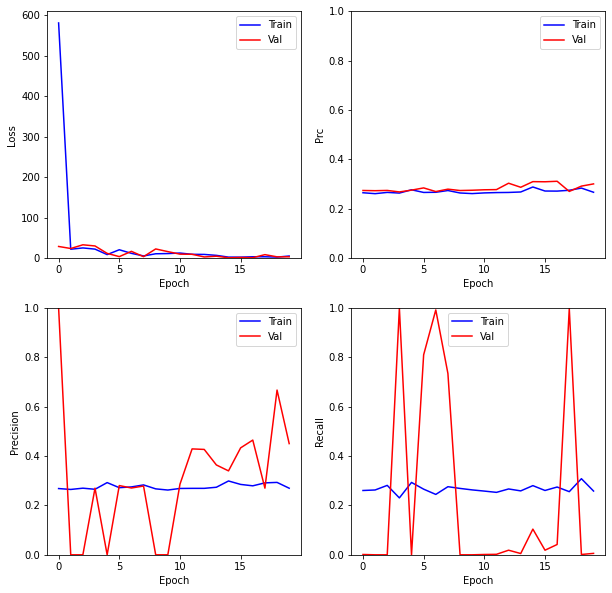

In [ ]:
plot_history(history_model5b_inresnet)

-----TEST--------
8/8 [==============================] - 12s 557ms/step - loss: 3.6585 - tp: 10.0000 - fp: 12.0000 - tn: 2762.0000 - fn: 1038.0000 - accuracy: 0.7253 - precision: 0.4545 - recall: 0.0095 - auc: 0.5224 - prc: 0.3049
loss :  3.658522367477417
tp :  10.0
fp :  12.0
tn :  2762.0
fn :  1038.0
accuracy :  0.7252747416496277
precision :  0.4545454680919647
recall :  0.009541984647512436
auc :  0.5224189162254333
prc :  0.3049401342868805
-------------
-----VAL--------
12/12 [==============================] - 6s 510ms/step - loss: 3.6289 - tp: 9.0000 - fp: 11.0000 - tn: 4203.0000 - fn: 1549.0000 - accuracy: 0.7297 - precision: 0.4500 - recall: 0.0058 - auc: 0.5265 - prc: 0.3011
loss :  3.6288859844207764
tp :  9.0
fp :  11.0
tn :  4203.0
fn :  1549.0
accuracy :  0.7297297120094299
precision :  0.44999998807907104
recall :  0.005776636768132448
auc :  0.5264788866043091
prc :  0.3010749816894531
-------------
8/8 [==============================] - 16s 2s/step
3822
              

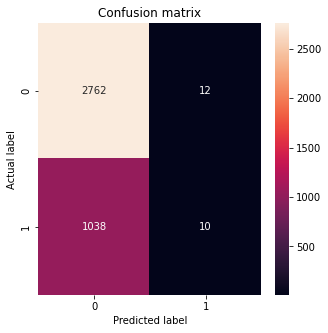

In [ ]:
eval_df=bmodel_eval(model5b_inresnet, 11, 'Model5b InceptionResnetV2', test_b, val_b)

In [ ]:
#ran with batch size=512

es=EarlyStopping(monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

history_model4b_inresnet2 =model4b_inresnet.fit(train_b,
                            validation_data=val_b,
                            epochs=30,
                            verbose=1,
                            callbacks=[es]                  
                            )

model4b_inresnet.save('/content/drive/MyDrive/GA/Capstone/BinaryModels/model4b_inresnet2.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model4b_inresnet2_history.pkl','wb') as model_history:
  pkl.dump(history_model4b_inresnet2, model_history)

In [ ]:
model4b_inresnet2=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/BinaryModels/model4b_inresnet2.h5')


with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model4b_inresnet2_history.pkl','rb') as model_history:
 history_model4b_inresnet2 =pkl.load(model_history)

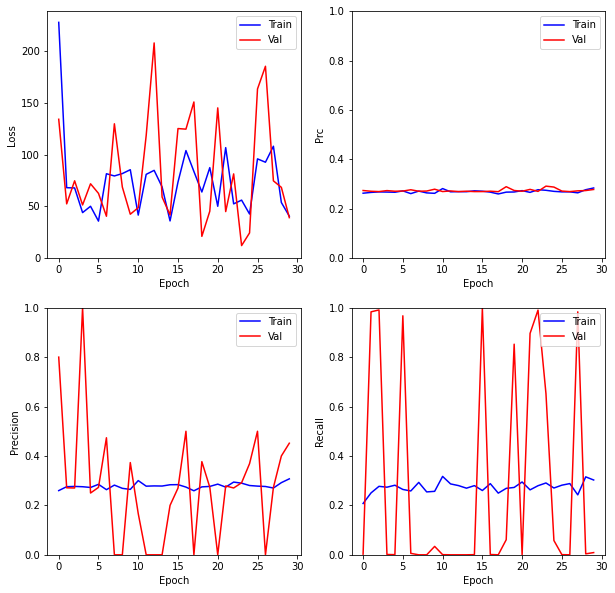

In [ ]:
plot_history(history_model4b_inresnet2)

-----TEST--------
8/8 [==============================] - 9s 566ms/step - loss: 39.4516 - tp: 6.0000 - fp: 16.0000 - tn: 2758.0000 - fn: 1042.0000 - accuracy: 0.7232 - precision: 0.2727 - recall: 0.0057 - auc: 0.4996 - prc: 0.2736
loss :  39.45158767700195
tp :  6.0
fp :  16.0
tn :  2758.0
fn :  1042.0
accuracy :  0.7231816053390503
precision :  0.27272728085517883
recall :  0.0057251909747719765
auc :  0.49955856800079346
prc :  0.27359211444854736
-------------
-----VAL--------
12/12 [==============================] - 6s 502ms/step - loss: 39.2281 - tp: 14.0000 - fp: 17.0000 - tn: 4197.0000 - fn: 1544.0000 - accuracy: 0.7296 - precision: 0.4516 - recall: 0.0090 - auc: 0.5038 - prc: 0.2785
loss :  39.228118896484375
tp :  14.0
fp :  17.0
tn :  4197.0
fn :  1544.0
accuracy :  0.7295565009117126
precision :  0.4516128897666931
recall :  0.008985878899693489
auc :  0.5038079619407654
prc :  0.2784923315048218
-------------
8/8 [==============================] - 8s 559ms/step
3822
        

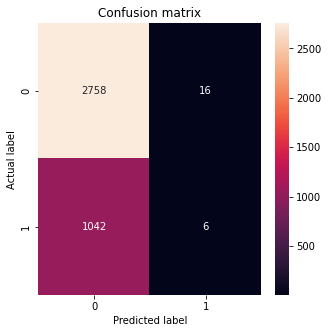

In [ ]:
eval_df=bmodel_eval(model4b_inresnet2, 12, 'Model4b InceptionResnetV2 512 batch', test_b, val_b)

# Model Evaluation

## Baseline Accuracy

In [ ]:
train_label_df['label_b'].value_counts()

0    21279
1     7581
Name: label_b, dtype: int64

In [ ]:
train_label_df['label_b'].value_counts(normalize=True)

0    0.737318
1    0.262682
Name: label_b, dtype: float64

Baseline Accuracy for binary classification is 0.74

## Evaluation

In [7]:
eval_df=pd.read_csv('/content/drive/MyDrive/GA/Capstone/BinaryModels/model_evaluation.csv')

In [ ]:
eval_df.head(7)

,class,precision,recall,f1-score,support,auc,prc,model_no,comment
0,0,0.725798,1.000000,0.841116,2774.000000,0.500000,0.274202,1,Model1 b CNN
1,1,0.000000,0.000000,0.000000,1048.000000,0.500000,0.274202,1,Model1 b CNN
2,accuracy,0.725798,0.725798,0.725798,0.725798,0.500000,0.274202,1,Model1 b CNN
3,macro avg,0.362899,0.500000,0.420558,3822.000000,0.500000,0.274202,1,Model1 b CNN
4,weighted avg,0.526783,0.725798,0.610480,3822.000000,0.500000,0.274202,1,Model1 b CNN
5,0,0.750417,0.811824,0.779913,2774.000000,0.594943,0.341569,2,Model1 b CNN weighted
6,1,0.364190,0.285305,0.319957,1048.000000,0.594943,0.341569,2,Model1 b CNN weighted


### Recall Analysis

In [8]:
eval_df_recall = eval_df.pivot(index='model_no', columns='class', values='recall')

In [9]:
eval_df_recall

class,0,1,accuracy,macro avg,weighted avg
model_no,,,,,
1,1.000000,0.000000,0.725798,0.500000,0.725798
2,0.811824,0.285305,0.667452,0.548565,0.667452
3,0.797044,0.370229,0.680010,0.583636,0.680010
4,0.578947,0.537214,0.567504,0.558081,0.567504
5,1.000000,0.000000,0.730000,0.500000,0.730000
6,0.838500,0.315840,0.695186,0.577170,0.695186
7,0.828767,0.381679,0.706175,0.605223,0.706175
8,0.895458,0.289122,0.729199,0.592290,0.729199
9,0.230714,0.816794,0.391418,0.523754,0.391418


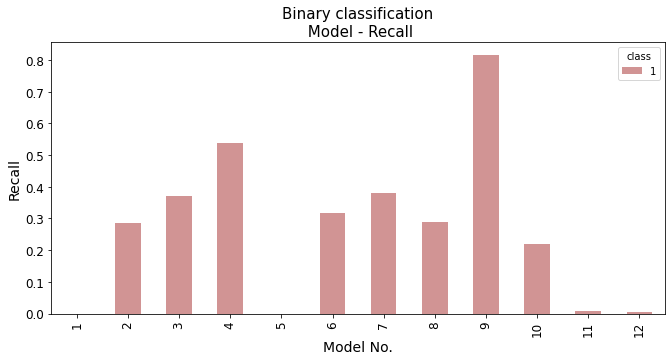

In [27]:
eval_df_recall[['1']].plot(kind='bar', figsize=(11,5), color='brown', width= 0.5,alpha=0.5);
# eval_df_recall2['macro avg'].plot(kind='bar', figsize=(15,6), width= 0.5,)
plt.legend(title='class')
# plt.axhline(y=0.5, linestyle='--', color='orange')
plt.title('Binary classification\n Model - Recall', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Model No.', size=14)
plt.ylabel('Recall', size=14);
# plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.2);
plt.savefig('/content/drive/MyDrive/Github/Diabetic_Retinopethy_Image_Classification/images/binary_classification_recall1.png');

The bar chart shown above displays the Recall for class 1 for all the models. As shown above, there are two models that show recall >0.5 for class 1, model 4 and model 9. We will consider model 9 as a possible production model since it has considerable higher recall for class 1 which is important for this classification.

### F1-score Analysis

In [ ]:
eval_df_f1score= eval_df.pivot(index='model_no', columns='class', values='f1-score')

In [ ]:
eval_df_f1score

class,0,1,accuracy,macro avg,weighted avg
model_no,,,,,
1,0.841116,0.000000,0.725798,0.420558,0.610480
2,0.779913,0.319957,0.667452,0.549935,0.653793
3,0.783348,0.388194,0.680010,0.585771,0.674996
4,0.660226,0.405182,0.567504,0.532704,0.590292
5,0.840000,0.000000,0.730000,0.420000,0.610000
6,0.799725,0.362343,0.695186,0.581034,0.679794
7,0.803706,0.416017,0.706175,0.609861,0.697401
8,0.827586,0.369287,0.729199,0.598437,0.701920
9,0.354964,0.423972,0.391418,0.389468,0.373886


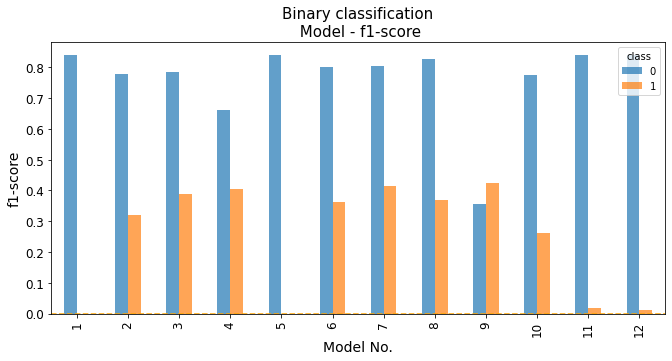

In [ ]:
eval_df_f1score[['0','1']].plot(kind='bar', figsize=(11,5), width= 0.5,alpha=0.7);
plt.legend(title='class')
# eval_df_recall2['macro avg'].plot(kind='bar', figsize=(15,6), width= 0.5,)
plt.axhline( linestyle='--', color='orange')
plt.title('Binary classification\n Model - f1-score', size=15)
plt.xlabel('Model No.', size=14)
plt.ylabel('f1-score', size=14);
plt.xticks(size=12)
plt.yticks(size=12);
plt.savefig('/content/drive/MyDrive/Github/Diabetic_Retinopethy_Image_Classification/images/binary_classification_f1score.png');

The bar chart above shows f1-score for all the models for class 0 and 1. Model 4 and model 9 show similar f1-scores.

### AUC Analysis

In [23]:
eval_df_auc= eval_df.pivot(index='model_no', columns='class', values='auc')

In [24]:
eval_df_auc

class,0,1,accuracy,macro avg,weighted avg
model_no,,,,,
1,0.500000,0.500000,0.500000,0.500000,0.500000
2,0.594943,0.594943,0.594943,0.594943,0.594943
3,0.629675,0.629675,0.629675,0.629675,0.629675
4,0.580247,0.580247,0.580247,0.580247,0.580247
5,0.620955,0.620955,0.620955,0.620955,0.620955
6,0.628997,0.628997,0.628997,0.628997,0.628997
7,0.652677,0.652677,0.652677,0.652677,0.652677
8,0.648681,0.648681,0.648681,0.648681,0.648681
9,0.525569,0.525569,0.525569,0.525569,0.525569


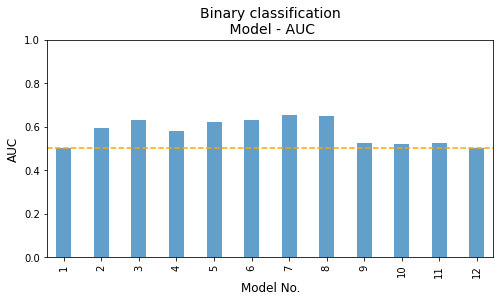

In [26]:
eval_df_auc[['1']].plot(kind='bar', figsize=(8,4), width= 0.4, alpha=0.7);
# eval_df_recall2['macro avg'].plot(kind='bar', figsize=(15,6), width= 0.5,)
plt.axhline(y=0.5, linestyle='--', color='orange')
plt.title('Binary classification\n Model - AUC', size=14)
plt.legend().remove()
plt.xlabel('Model No.', size=12)
plt.ylabel('AUC', size=12);
plt.xticks(size=10)
plt.yticks(size=10);
plt.ylim(0,1);
plt.savefig('/content/drive/MyDrive/Github/Diabetic_Retinopethy_Image_Classification/images/binary_classification_auc.png');

The bar chart above show AUC for ROC for all the models. Both our models of interest- model 4 and 9 have AUC>0.5.

### Accuracy Analysis

In [ ]:
eval_df_acc= eval_df.pivot(index='model_no', columns='class', values='f1-score')

In [ ]:
eval_df_acc

class,0,1,accuracy,macro avg,weighted avg
model_no,,,,,
1,0.841116,0.000000,0.725798,0.420558,0.610480
2,0.779913,0.319957,0.667452,0.549935,0.653793
3,0.783348,0.388194,0.680010,0.585771,0.674996
4,0.660226,0.405182,0.567504,0.532704,0.590292
5,0.840000,0.000000,0.730000,0.420000,0.610000
6,0.799725,0.362343,0.695186,0.581034,0.679794
7,0.803706,0.416017,0.706175,0.609861,0.697401
8,0.827586,0.369287,0.729199,0.598437,0.701920
9,0.354964,0.423972,0.391418,0.389468,0.373886


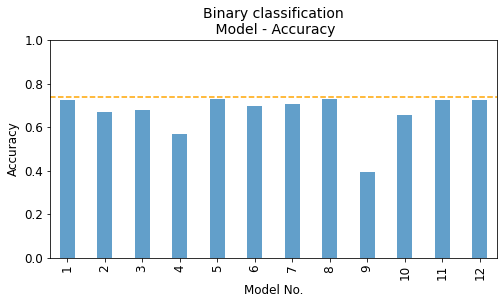

In [ ]:
eval_df_acc[['accuracy']].plot(kind='bar', figsize=(8,4), width= 0.4, alpha=0.7);
# eval_df_recall2['macro avg'].plot(kind='bar', figsize=(15,6), width= 0.5,)
plt.axhline(y=0.74, linestyle='--', color='orange')
plt.title('Binary classification\n Model - Accuracy', size=14)
plt.legend().remove()
plt.xlabel('Model No.', size=12)
plt.ylabel('Accuracy', size=12);
plt.xticks(size=12)
plt.ylim(0,1)
plt.yticks(size=12);
plt.savefig('/content/drive/MyDrive/Github/Diabetic_Retinopethy_Image_Classification/images/binary_classification_accuracy.png');

Our baseline accuracy for binary classification is 0.74 but we have highly imbalanced classes. Model 9 has an accuracy of 0.4.

# Production Model

Based on the Recall analysis above, model 9 (transfer learning-InceptionResNet V2) will be selected as production model candidate since it has the highest recall for class 1. We want to have as less false negatives as possible for DR detection.   

Although this model has high recall, it gives lot of false positives and the auc is just above 0.5. This model will need more tuning to get a good balance between detection of both the classes. It can be further improved upon by fine tuning the transfer learning. Also, other techniques can be tried like more pre-processing, data augmentation or training on a small more balanced batch.